YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


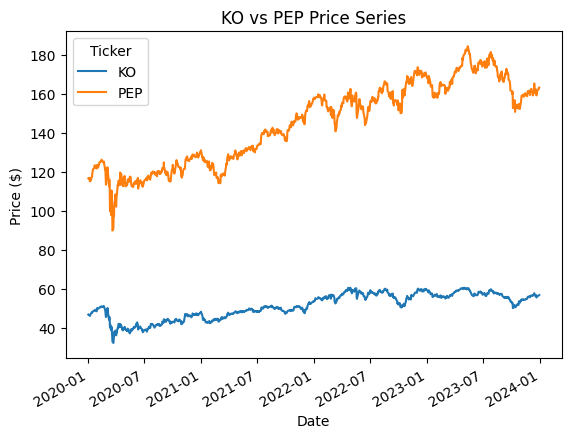

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf  # For fetching real stock data

# Fetch historical data for KO and PEP from Yahoo Finance
def fetch_data(tickers, start_date, end_date):
    """
    Download historical price data for given tickers
    Args:
        tickers (list): List of stock tickers (e.g., ['KO', 'PEP'])
        start_date (str): Start date in 'YYYY-MM-DD' format
        end_date (str): End date in 'YYYY-MM-DD' format
    Returns:
        pd.DataFrame: DataFrame with adjusted close prices
    """
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    return data

# Define time period and fetch data
tickers = ['KO', 'PEP']
start_date = '2020-01-01'
end_date = '2023-12-31'
data = fetch_data(tickers, start_date, end_date)

# Plot the price series to visualize correlation
data.plot(title='KO vs PEP Price Series')
plt.ylabel('Price ($)')
plt.show()

Missing values:
 Ticker
KO     0
PEP    0
dtype: int64


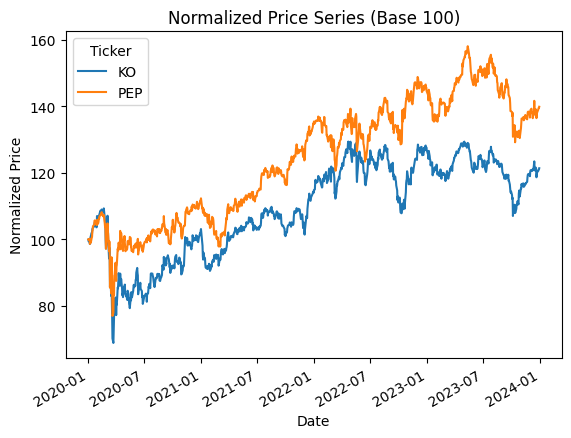

Correlation coefficient between KO and PEP: 0.9350


In [2]:
# Check for missing values
print("Missing values:\n", data.isnull().sum())

# Normalize prices to compare movement patterns
normalized_data = data.div(data.iloc[0]).mul(100)
normalized_data.plot(title='Normalized Price Series (Base 100)')
plt.ylabel('Normalized Price')
plt.show()

# Calculate correlation coefficient
correlation = data['KO'].corr(data['PEP'])
print(f"Correlation coefficient between KO and PEP: {correlation:.4f}")

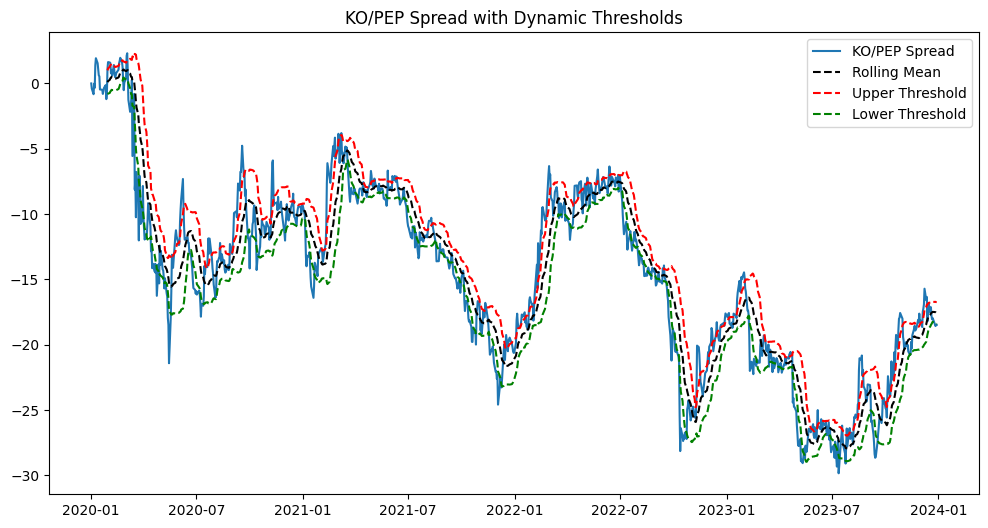

In [12]:
# Calculate spread  
normalized_data['Spread'] = normalized_data['KO'] - normalized_data['PEP']

# Calculate rolling statistics for dynamic thresholds
window = 20  # 20 trading days (~1 month)
normalized_data['Spread_Mean'] = normalized_data['Spread'].rolling(window).mean()
normalized_data['Spread_Std'] = normalized_data['Spread'].rolling(window).std()

# Define thresholds  
threshold_multiplier = 1
normalized_data['Upper_Threshold'] = normalized_data['Spread_Mean'] + threshold_multiplier * normalized_data['Spread_Std']
normalized_data['Lower_Threshold'] = normalized_data['Spread_Mean'] - threshold_multiplier * normalized_data['Spread_Std']

# Plot spread with thresholds
plt.figure(figsize=(12, 6))
plt.plot(normalized_data['Spread'], label='KO/PEP Spread')
plt.plot(normalized_data['Spread_Mean'], label='Rolling Mean', color='black', linestyle='--')
plt.plot(normalized_data['Upper_Threshold'], label='Upper Threshold', color='red', linestyle='--')
plt.plot(normalized_data['Lower_Threshold'], label='Lower Threshold', color='green', linestyle='--')
plt.title('KO/PEP Spread with Dynamic Thresholds')
plt.legend()
plt.show()

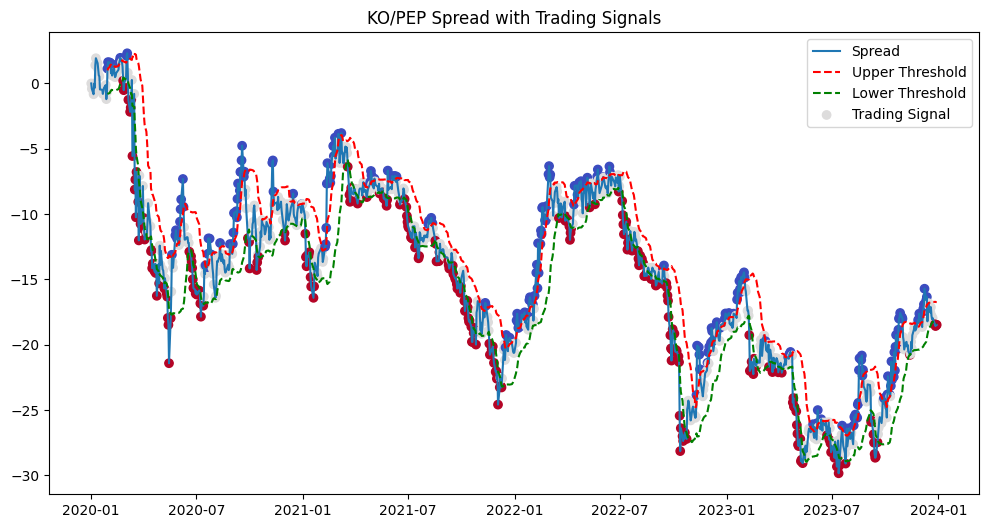

In [ ]:
# Initialize signals
normalized_data['Signal'] = 0

# Generate signals based on spread crossing thresholds
# When spread is too high: short KO, long PEP
normalized_data.loc[normalized_data['Spread'] > normalized_data['Upper_Threshold'], 'Signal'] = -1  # Short KO, Long PEP

# When spread is too low: long KO, short PEP
normalized_data.loc[normalized_data['Spread'] < normalized_data['Lower_Threshold'], 'Signal'] = 1   # Long KO, Short PEP

data['Signal'] = normalized_data['Signal']

# Plot signals
plt.figure(figsize=(12, 6))
plt.plot(normalized_data['Spread'], label='Spread')
plt.plot(normalized_data['Upper_Threshold'], color='red', linestyle='--', label='Upper Threshold')
plt.plot(normalized_data['Lower_Threshold'], color='green', linestyle='--', label='Lower Threshold')
plt.scatter(normalized_data.index, normalized_data['Spread'], c=normalized_data['Signal'], cmap='coolwarm', label='Trading Signal')
plt.title('KO/PEP Spread with Trading Signals')
plt.legend() 
plt.show()

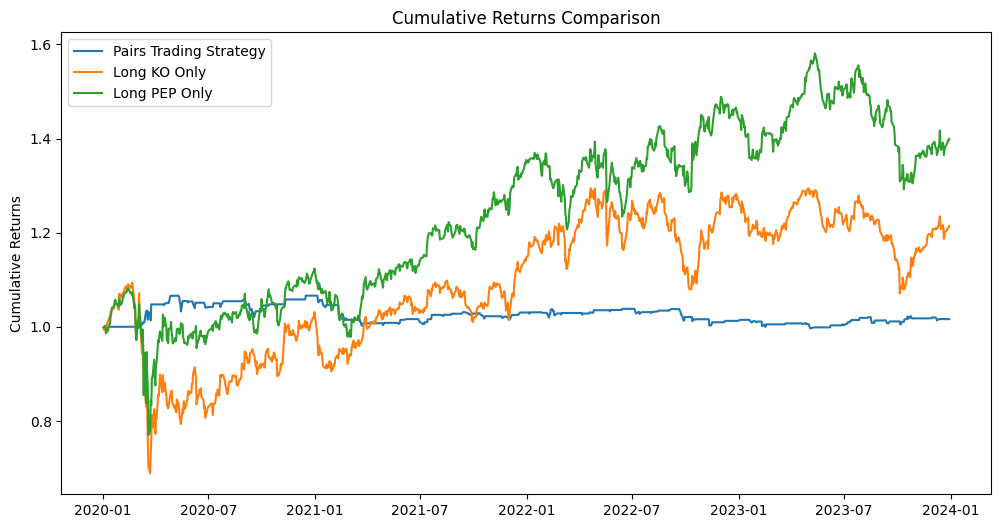

In [9]:
# Calculate positions
data['Position_KO'] = data['Signal']  # Long/short KO
data['Position_PEP'] = -data['Signal']  # Opposite position in PEP

# Calculate daily returns for each stock
data['Return_KO'] = data['KO'].pct_change()
data['Return_PEP'] = data['PEP'].pct_change()

# Calculate strategy returns (assuming equal dollar amounts)
data['Strategy_Return'] = 0.5 * (data['Position_KO'].shift(1) * data['Return_KO']) +  0.5 * (data['Position_PEP'].shift(1) * data['Return_PEP'])

# Calculate cumulative returns
data['Cumulative_Strategy'] = (1 + data['Strategy_Return']).cumprod()
data['Cumulative_KO'] = (1 + data['Return_KO']).cumprod()
data['Cumulative_PEP'] = (1 + data['Return_PEP']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Strategy'], label='Pairs Trading Strategy')
plt.plot(data['Cumulative_KO'], label='Long KO Only')
plt.plot(data['Cumulative_PEP'], label='Long PEP Only')
plt.title('Cumulative Returns Comparison')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()